# LRA based attacks

## Outline

[Content](#content)

[Prerequisite packages and settings](#prerequisite-packages-and-settings)

[Targeted cryptographic function $f$: AES Sbox](#aes)

- [Step 1: Traces generation and preprocessing](#aes-step-1)

- [Step 2: Attack phase](#aes-step-2)

[Targeted cryptographic function $f$: XOR operation](#xor)

- [Step 1: Traces generation and preprocessing](#xor-step-1)

- [Step 2: Attack phase](#xor-step-2)

[Targeted cryptographic function $f$: Prince Sbox](#prince)

- [Step 1: Traces generation and preprocessing](#prince-step-1)

- [Step 2: Attack phase](#prince-step-2)

[Targeted cryptographic function $f$: Clyde128 Sbox](#clyde)

- [Step 1: Traces generation and preprocessing](#clyde-step-1)

- [Step 2: Attack phase](#clyde-step-2)


## Content <a class='anchor' id='content'></a>

In this notebook, we propose to conduct non profiled attacks using Linear Regression Analysis with our proposed distinguishers considering different targeted cryptographic functions $f$.

To do so, we propose in this notebook to attack simulated traces. 
For each targeted cryptographic function $f$, we first generate a set of attack traces. 
Then LRA based attacks are done considering state-of-the-art distinguishers and our proposed distinguishers (see Section 4).

This notebook is provided as an example. In particular, users are free to adapt this notebook to suit the dataset they want to target.

## Prerequisite packages and settings <a class='anchor' id='prerequisite-packages-and-settings'></a>

Here are the Python packages and settings needed to run properly this notebook.

In [1]:
from LRA.LRA_implementations import *
from LRA.LRA_utils import *
from matplotlib import pyplot as plt

plt.rcParams['text.usetex'] = True

/home/boussams/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Targeted cryptographic function $f$: AES Sbox <a class='anchor' id='aes'></a>

In this section, the cryptographic function considered is AES Sbox.
The first step consists thus in generating traces manipulating AES Sbox output as targeted variables.
Then, we carry out LRA based attacks considering state-of-the-art distinguishers and our proposed distinguishers.
Finally we compare attack performances obtained using as attack metric the guessing entropy *i.e.* expected rank of the true key $k^*$.

### Step 1: Traces generation and preprocessing <a class='anchor' id='aes-step-1'></a>

The generation of traces is done using a function called $\texttt{generate\_traces}$, available in $\texttt{LRA\_utils.py}$ file. 

In the following example, we generate $100,000$ attack traces of $1,000$ samples such that $1\%$ are PoIs. 
We consider the fourth scenario with a non-isotropic Gaussian noise of parameters $\mu=0$ and $\sigma=\{1,5,10\}$.
The targeted byte is $0$ and the key is $k^*=\texttt{0x4a}$. 

We set the seed to $42$ to have reproductible results. 

In [2]:
# Traces generation
targeted_byte = 0
aes_true_key = [0x4a]

aes_attack_traces, aes_attack_plaintexts, aes_attack_targeted_variables, aes_sigmas = generate_traces(nb_traces=100000, nb_samples=1000, nb_poi=10, mu=0, isotropic_noise=False,\
                                                                                                      sigmas=np.array([1,5,10]), scenario="scenario_4", targeted_variables_type='aes_sbox', \
                                                                                                      targeted_variables_size=8, targeted_byte=targeted_byte, key=aes_true_key, seed=42)
                                                                        
print("Attack traces generated \U00002705")

Attack traces generated ✅


Here is an example of generated traces.

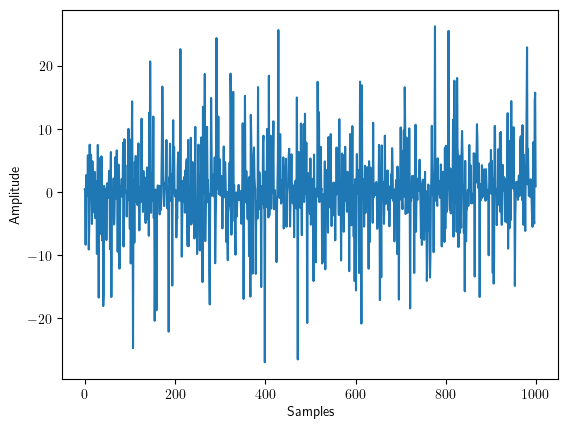

In [3]:
# Plot of a trace
plt.plot(aes_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Then, we apply on these traces preprocessing techniques. Specifically, we standardize traces (see Section 5.1.1 in our paper, paragraph *Configuration*).

In [4]:
from sklearn.preprocessing import StandardScaler

aes_std_scaler = StandardScaler()

aes_attack_traces = aes_std_scaler.fit_transform(aes_attack_traces)

The amplitude of traces is rescaled.

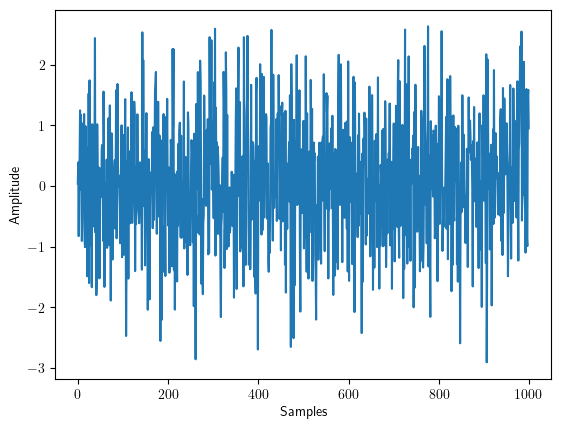

In [5]:
# Plot of a rescaled trace
plt.plot(aes_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Step 2: Attack phase <a class='anchor' id='aes-step-2'></a>

Once attack traces are generated, we carry out LRA attacks using $\texttt{LRA\_averaged\_attacks}$ function (see $\texttt{LRA\_implementations.py}$ file) considering $\texttt{nb\_traces}=[1000, 2000, 2500, 3000, 5000, 10000]$ traces.
For all attacks, we consider coalesced LRA.
For each traces number, we compute mean rank evolutions by averaging over $\texttt{total\_nb\_attack}=10$ attacks. 

All attacks are conducted with a full basis *i.e.* all bits interactions are taken into account and considering $R^2$ distinguisher, normalized $R^2$ distinguisher and maximum distinguisher (see Section 4.1.3, Proposition 4 in our paper).

<u>Reminder:</u> the basis used to perform LRA attacks considering all bits interactions is the Walsh-Hadamard basis (see Section 2.1, paragraph *Bases considered in SCA* of our paper).

In [6]:
# Running LRA attacks on simulated traces
from LRA.LRA_utils import aes_sbox_vectorized
nb_traces = [1000, 2000, 2500, 3000, 5000, 10000]

aes_mean_rank_max_dist, aes_mean_rank_r2, aes_mean_rank_norm_r2 = LRA_averaged_attacks(total_nb_attack=10, LRA_attack='LRA', true_key=aes_true_key[targeted_byte], \
                                                                                       nb_traces=nb_traces, attack_traces=aes_attack_traces, attack_plaintexts=aes_attack_plaintexts,\
                                                                                       len_basis=256, deg_monomials_interactions=8, nb_possible_plaintexts_values=256, nb_hypothesis=256,\
                                                                                       targeted_f_type='sbox', sbox=aes_sbox_vectorized, distinguisher='maximum_distinguisher')

print("Attacks done \U00002705")

100%|██████████| 6/6 [17:29<00:00, 174.98s/it]

Attacks done ✅


Now, we plot for each distinguisher its mean rank evolution.

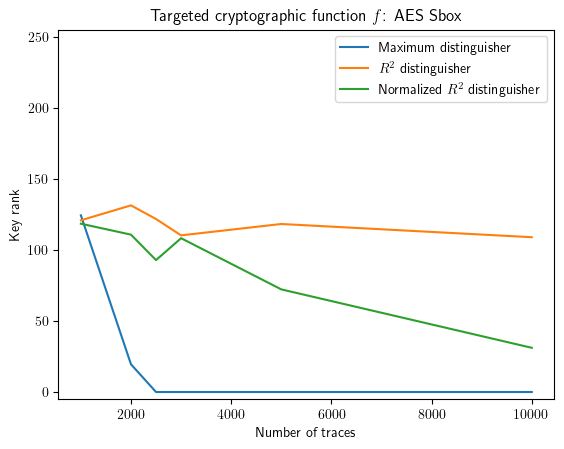

In [7]:
# Plot of mean rank evolutions for all considered distinguishers
plt.plot(nb_traces, aes_mean_rank_max_dist)
plt.plot(nb_traces, aes_mean_rank_r2)
plt.plot(nb_traces, aes_mean_rank_norm_r2)
plt.legend([r'Maximum distinguisher', r'$R^2$ distinguisher', r'Normalized $R^2$ distinguisher'])
plt.title(r'Targeted cryptographic function $f$: AES Sbox')
plt.xlabel("Number of traces")
plt.ylabel("Key rank")
plt.ylim([-5, 255])
plt.show()

As we can see, the correct key is recovered only when considering our proposed distinguisher. 
The number of traces required to retrieve the key is $2,500$.

## Targeted cryptographic function $f$: XOR operation <a class='anchor' id='xor'></a>

In this section, the cryptographic function considered is a XOR operation.
The first step consists thus in generating traces manipulating a XOR operation as targeted variables.
Then, we carry out LRA based attacks considering state-of-the-art distinguishers and our proposed distinguishers.
Finally we compare attack performances obtained using as attack metric the guessing entropy *i.e.* expected rank of the true key $k^*$.

### Step 1: Traces generation and preprocessing <a class='anchor' id='xor-step-1'></a>

The generation of traces is done using a function called $\texttt{generate\_traces}$, available in $\texttt{LRA\_utils.py}$ file. 

In the following example, we generate $100,000$ attack traces of $1,000$ samples such that $1\%$ are PoIs. 
We consider the fourth scenario with a non-isotropic Gaussian noise of parameters $\mu=0$ and $\sigma=\{1,5,10\}$.
The targeted byte is $0$ and the key is $k^*=\texttt{0x4a}$. 

We set the seed to $42$ to have reproductible results. 

In [8]:
# Traces generation
targeted_byte = 0
xor_true_key = [0x4a]

xor_attack_traces, xor_attack_plaintexts, xor_attack_targeted_variables, xor_sigmas = generate_traces(nb_traces=100000, nb_samples=1000, nb_poi=10, mu=0, isotropic_noise=False, \
                                                                                                      sigmas=np.array([1,5,10]), scenario="scenario_4", targeted_variables_type='xor', \
                                                                                                      targeted_variables_size=8, targeted_byte=targeted_byte, key=xor_true_key, seed=42)
                                                                        
print("Attack traces generated \U00002705")


Attack traces generated ✅


Here is an example of generated traces.

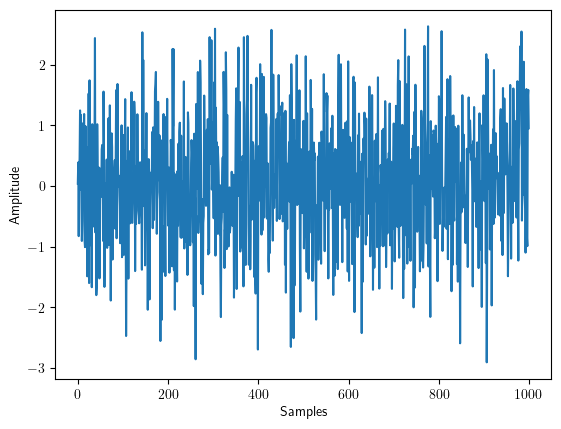

In [9]:
# Plot of a trace
plt.plot(xor_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Then, we apply on these traces preprocessing techniques. Specifically, we standardize traces (see Section 5.1.1 in our paper, paragraph *Configuration*).

In [10]:
from sklearn.preprocessing import StandardScaler

xor_std_scaler = StandardScaler()

xor_attack_traces = xor_std_scaler.fit_transform(xor_attack_traces)

The amplitude of traces is rescaled.

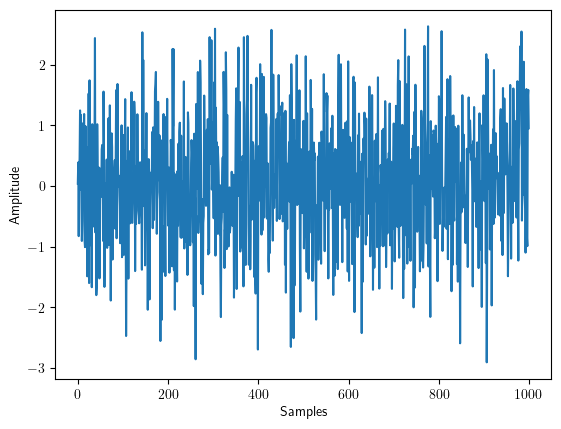

In [11]:
# Plot of a rescaled trace
plt.plot(xor_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Step 2: Attack phase <a class='anchor' id='xor-step-2'></a>

Once attack traces are generated, we carry out LRA attacks using $\texttt{LRA\_averaged\_attacks}$ function (see $\texttt{LRA\_implementations.py}$ file) considering $\texttt{nb\_traces}=[1000, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000]$ traces.
For all attacks, we consider coalesced LRA.
For each traces number, we compute mean rank evolutions by averaging over $\texttt{total\_nb\_attack}=10$ attacks. 

All attacks are conducted with a full basis *i.e.* all bits interactions are taken into account and considering $R^2$ distinguisher, normalized $R^2$ distinguisher and maximum distinguisher (see Section 4.1.3, Proposition 4 in our paper).

<u>Reminder:</u> the basis used to perform LRA attacks considering all bits interactions is the Walsh-Hadamard basis (see Section 2.1, paragraph *Bases considered in SCA* of our paper).

In [12]:
# Running LRA attacks on simulated traces
nb_traces = [1000, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000]

xor_mean_rank_abs_sum_dist, xor_mean_rank_r2, xor_mean_rank_norm_r2 = LRA_averaged_attacks(total_nb_attack=10, LRA_attack='LRA', true_key=xor_true_key[targeted_byte], \
                                                                                           nb_traces=nb_traces, attack_traces=xor_attack_traces, attack_plaintexts=xor_attack_plaintexts, \
                                                                                           len_basis=256, deg_monomials_interactions=8, nb_possible_plaintexts_values=256, nb_hypothesis=256, \
                                                                                           targeted_f_type='xor', sbox=None, distinguisher='absolute_value_sum_distinguisher')

print("Attacks done \U00002705")

  0%|          | 0/9 [00:00<?, ?it/s]/data/ssd/SBO/These/Papier LRA code en cours/LRA/LRA_implementations.py:45: RuntimeWarning: invalid value encountered in divide
  normalized_max = (max_u - mu_R2_scores)/sigma_R2_scores
100%|██████████| 9/9 [24:14<00:00, 161.62s/it]

Attacks done ✅


Now, we plot for each distinguisher its mean rank evolution.

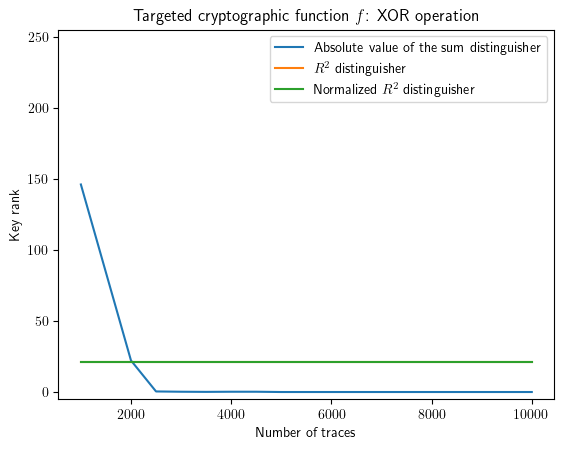

In [13]:
# Plot of mean rank evolutions for all considered distinguishers
plt.plot(nb_traces, xor_mean_rank_abs_sum_dist)
plt.plot(nb_traces, xor_mean_rank_r2)
plt.plot(nb_traces, xor_mean_rank_norm_r2)
plt.legend([r'Absolute value of the sum distinguisher', r'$R^2$ distinguisher', r'Normalized $R^2$ distinguisher'])
plt.xlabel("Number of traces")
plt.ylabel("Key rank")
plt.title(r'Targeted cryptographic function $f$: XOR operation')
plt.ylim([-5, 255])
plt.show()

As we can see, the correct key is recovered only when considering our proposed distinguisher, within $3,000$ traces.

## Targeted cryptographic function $f$: Prince Sbox <a class='anchor' id='prince'></a>

In this section, the cryptographic function considered is Prince Sbox.
The first step consists thus in generating traces manipulating Prince Sbox output as targeted variables.
Then, we carry out LRA based attacks considering state-of-the-art distinguishers and our proposed distinguishers.
Finally we compare attack performances obtained using as attack metric the guessing entropy *i.e.* expected rank of the true key $k^*$.

### Step 1: Traces generation <a class='anchor' id='prince-step-1'></a>

The generation of traces is done using a function called $\texttt{generate\_traces}$, available in $\texttt{LRA\_utils.py}$ file. 

In the following example, we generate $100,000$ attack traces of $1,000$ samples such that $1\%$ are PoIs. 
We consider the fourth scenario with a non-isotropic Gaussian noise of parameters $\mu=0$ and $\sigma=\{1,5,10\}$.
We consider the first four bits of the true key: $k^*=\texttt{0xa}$. 

We set the seed to $42$ to have reproductible results. 

In [14]:
# Traces generation
index_targeted_four_bits = 0
prince_true_key = [0xa]

prince_attack_traces, prince_attack_plaintexts, prince_attack_targeted_variables, prince_sigmas = generate_traces(nb_traces=100000, nb_samples=1000, nb_poi=10, mu=0, isotropic_noise=False, \
                                                                                                                  sigmas=np.array([1,5,10]), alpha=np.array([1, 0.5, 1, 0]), \
                                                                                                                  beta=np.array([1, 2, 0.5, 0.25, 1, 0.15, 1, 0.4, 0.3, 0.6, 0.2, 0.1]), \
                                                                                                                  scenario="scenario_4", targeted_variables_type='prince_sbox', \
                                                                                                                  targeted_variables_size=4, targeted_byte=index_targeted_four_bits, \
                                                                                                                  key=prince_true_key, seed=42)
                                                                        
print("Attack traces generated \U00002705")

Attack traces generated ✅


Here is an example of generated traces.

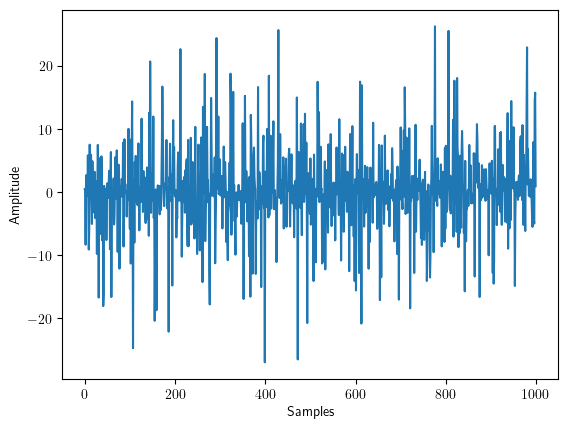

In [15]:
# Plot of a trace
plt.plot(prince_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Then, we apply on these traces preprocessing techniques. Specifically, we standardize traces (see Section 5.1.1 in our paper, paragraph *Configuration*).

In [16]:
from sklearn.preprocessing import StandardScaler

prince_std_scaler = StandardScaler()

prince_attack_traces = prince_std_scaler.fit_transform(prince_attack_traces)

The amplitude of traces is rescaled.

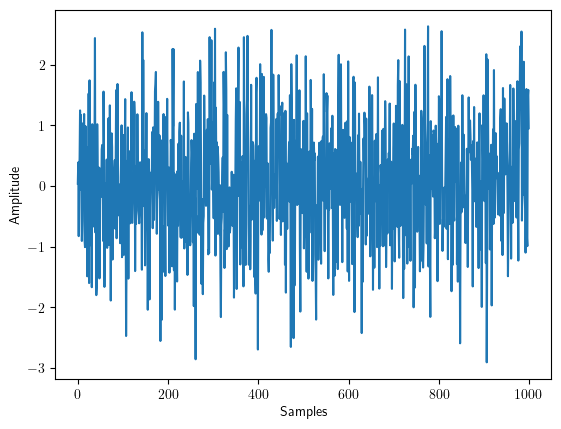

In [17]:
# Plot of a rescaled trace
plt.plot(prince_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Step 2: Attack phase <a class='anchor' id='prince-step-2'></a>

Once attack traces are generated, we carry out LRA attacks using $\texttt{LRA\_averaged\_attacks}$ function (see $\texttt{LRA\_implementations.py}$ file) considering $\texttt{nb\_traces}=[50, 100, 150, 200, 250, 300, 400, 500]$ traces.
For all attacks, we consider coalesced LRA.
For each traces number, we compute mean rank evolutions by averaging over $\texttt{total\_nb\_attack}=10$ attacks. 

All attacks are conducted with a full basis *i.e.* all bits interactions are taken into account and considering $R^2$ distinguisher, normalized $R^2$ distinguisher and maximum distinguisher (see Section 4.1.3, Proposition 4 in our paper).

<u>Reminder:</u> the basis used to perform LRA attacks considering all bits interactions is the Walsh-Hadamard basis (see Section 2.1, paragraph *Bases considered in SCA* of our paper).

In [18]:
# Running LRA attacks on simulated traces
from LRA.LRA_utils import prince_sbox_vectorized
nb_traces = [50, 100, 150, 200, 250, 300, 400, 500]

prince_mean_rank_max_dist, prince_mean_rank_r2, prince_mean_rank_norm_r2 = LRA_averaged_attacks(total_nb_attack=10, LRA_attack='LRA', \
                                                                                                true_key=prince_true_key[index_targeted_four_bits], nb_traces=nb_traces, \
                                                                                                attack_traces=prince_attack_traces, attack_plaintexts=prince_attack_plaintexts, len_basis=16,\
                                                                                                deg_monomials_interactions=4, nb_possible_plaintexts_values=16, nb_hypothesis=16, \
                                                                                                targeted_f_type='sbox', sbox=prince_sbox_vectorized, distinguisher='maximum_distinguisher')

print("Attacks done \U00002705")

  0%|          | 0/8 [00:00<?, ?it/s]/data/ssd/SBO/These/Papier LRA code en cours/LRA/LRA_implementations.py:45: RuntimeWarning: invalid value encountered in divide
  normalized_max = (max_u - mu_R2_scores)/sigma_R2_scores
100%|██████████| 8/8 [00:01<00:00,  4.38it/s]

Attacks done ✅


Now, we plot for each distinguisher its mean rank evolution.

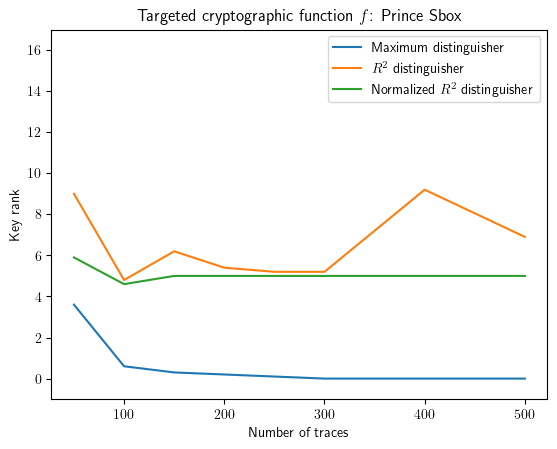

In [19]:
# Plot of mean rank evolutions for all considered distinguishers
plt.plot(nb_traces, prince_mean_rank_max_dist)
plt.plot(nb_traces, prince_mean_rank_r2)
plt.plot(nb_traces, prince_mean_rank_norm_r2)
plt.legend([r'Maximum distinguisher', r'$R^2$ distinguisher', r'Normalized $R^2$ distinguisher'])
plt.xlabel("Number of traces")
plt.ylabel("Key rank")
plt.title(r'Targeted cryptographic function $f$: Prince Sbox')
plt.ylim([-1, 17])
plt.show()

As we can see, the correct key is recovered only when considering our proposed distinguisher.
The correct key is retrieved within $300$ traces.

## Targeted cryptographic function $f$: Clyde128 Sbox <a class='anchor' id='clyde'></a>

In this section, the cryptographic function considered is Clyde128 Sbox.
The first step consists thus in generating traces manipulating Clyde128 Sbox output as targeted variables.
Then, we carry out LRA based attacks considering state-of-the-art distinguishers and our proposed distinguishers.
Finally we compare attack performances obtained using as attack metric the guessing entropy *i.e.* expected rank of the true key $k^*$.

### Step 1: Traces generation <a class='anchor' id='clyde-step-1'></a>

The generation of traces is done using a function called $\texttt{generate\_traces}$, available in $\texttt{LRA\_utils.py}$ file. 

In the following example, we generate $100,000$ attack traces of $1,000$ samples such that $1\%$ are PoIs. 
We consider the fourth scenario with a non-isotropic Gaussian noise of parameters $\mu=0$ and $\sigma=\{1,5,10\}$.
We consider the first four bits of the true key: $k^*=\texttt{0xa}$. 

We set the seed to $42$ to have reproductible results. 

In [20]:
# Traces generation
index_targeted_four_bits = 0
clyde_true_key = [0xa]

clyde_attack_traces, clyde_attack_plaintexts, clyde_attack_targeted_variables, clyde_sigmas = generate_traces(nb_traces=100000, nb_samples=1000, nb_poi=10, mu=0, isotropic_noise=False, \
                                                                                                              sigmas=np.array([1,5,10]), alpha=np.array([1, 0.5, 1, 0]), \
                                                                                                              beta=np.array([1, 2, 0.5, 0.25, 1, 0.15, 1, 0.4, 0.3, 0.6, 0.2, 0.1]), \
                                                                                                              scenario="scenario_4", targeted_variables_type='clyde_sbox', \
                                                                                                              targeted_variables_size=4, targeted_byte=index_targeted_four_bits, \
                                                                                                              key=clyde_true_key, seed=42)
                                                                        
print("Attack traces generated \U00002705")

Attack traces generated ✅


Here is an example of generated traces.

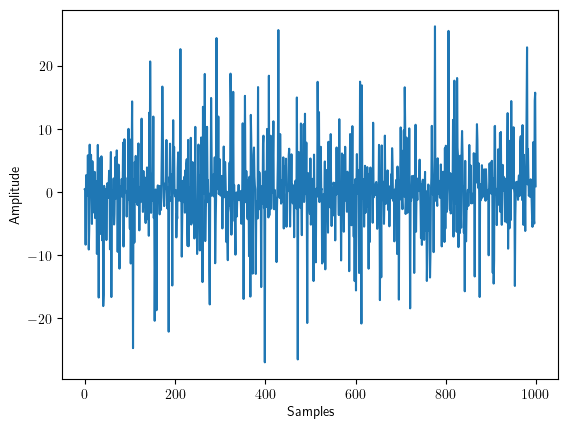

In [21]:
# Plot of a trace
plt.plot(clyde_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Then, we apply on these traces preprocessing techniques. Specifically, we standardize traces (see Section 5.1.1 in our paper, paragraph *Configuration*).

In [22]:
from sklearn.preprocessing import StandardScaler

clyde_std_scaler = StandardScaler()

clyde_attack_traces = clyde_std_scaler.fit_transform(clyde_attack_traces)

The amplitude of traces is rescaled.

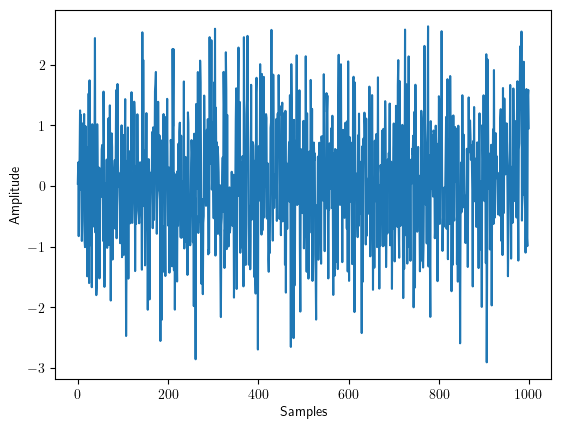

In [23]:
# Plot of a rescaled trace
plt.plot(clyde_attack_traces[0,:])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Step 2: Attack phase <a class='anchor' id='clyde-step-2'></a>

Once attack traces are generated, we carry out LRA attacks using $\texttt{LRA\_averaged\_attacks}$ function (see $\texttt{LRA\_implementations.py}$ file) considering $\texttt{nb\_traces}=[50, 100, 150, 200, 250, 300, 350, 400]$ traces.
For all attacks, we consider coalesced LRA.
For each traces number, we compute mean rank evolutions by averaging over $\texttt{total\_nb\_attack}=10$ attacks. 

All attacks are conducted with a full basis *i.e.* all bits interactions are taken into account and considering $R^2$ distinguisher, normalized $R^2$ distinguisher and maximum distinguisher (see Section 4.1.3, Proposition 4 in our paper).

<u>Reminder:</u> the basis used to perform LRA attacks considering all bits interactions is the Walsh-Hadamard basis (see Section 2.1, paragraph *Bases considered in SCA* of our paper).

In [24]:
# Running LRA attacks on simulated traces
from LRA.LRA_utils import clyde_sbox_vectorized
nb_traces = [50, 100, 150, 200, 250, 300, 350, 400]

clyde_mean_rank_abs_sum_dist, clyde_mean_rank_r2, clyde_mean_rank_norm_r2 = LRA_averaged_attacks(total_nb_attack=10, LRA_attack='LRA',\
                                                                                                 true_key=clyde_true_key[index_targeted_four_bits], nb_traces=nb_traces, \
                                                                                                 attack_traces=clyde_attack_traces, attack_plaintexts=clyde_attack_plaintexts, len_basis=16, \
                                                                                                 deg_monomials_interactions=4, nb_possible_plaintexts_values=16, nb_hypothesis=16, \
                                                                                                 targeted_f_type='sbox', sbox=clyde_sbox_vectorized, \
                                                                                                 distinguisher='absolute_value_sum_distinguisher')

print("Attacks done \U00002705")

  0%|          | 0/8 [00:00<?, ?it/s]/data/ssd/SBO/These/Papier LRA code en cours/LRA/LRA_implementations.py:45: RuntimeWarning: invalid value encountered in divide
  normalized_max = (max_u - mu_R2_scores)/sigma_R2_scores
100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

Attacks done ✅


Now, we plot for each distinguisher its mean rank evolution.

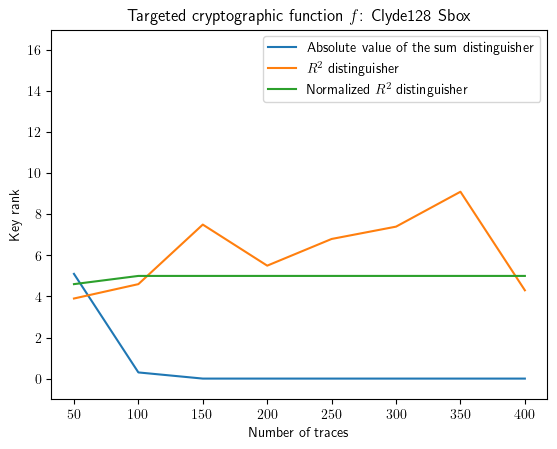

In [25]:
# Plot of mean rank evolutions for all considered distinguishers
plt.plot(nb_traces, clyde_mean_rank_abs_sum_dist)
plt.plot(nb_traces, clyde_mean_rank_r2)
plt.plot(nb_traces, clyde_mean_rank_norm_r2)
plt.legend([r'Absolute value of the sum distinguisher', r'$R^2$ distinguisher', r'Normalized $R^2$ distinguisher'])
plt.xlabel("Number of traces")
plt.ylabel("Key rank")
plt.title(r'Targeted cryptographic function $f$: Clyde128 Sbox')
plt.ylim([-1, 17])
plt.show()

As we can see, the correct key is recovered only when considering our proposed distinguisher, within $200$ traces.